In [5]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta

from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, skewtest, kurtosis

import sys, warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
def masking_all(x):
    if x.notnull().sum() ==25:
        return x
    else:
        return np.nan

In [7]:
dir = './'
f1 = sorted(glob.glob(dir+'CI_mixing_diag_final_corr/*_CI_prmask_PBLH.csv'))

pairings = ["SWC1_LE","SWC1_H","SWC1_EF","SWC1_NETRAD",         # Land --> Heat flux
            "LE_QA","EF_QA","H_TA",                             # Heat flux --> Near-surface meteorology
            "SWC1_LCL",                                         # Land --> Near-surface meteorology
            "LE_PBLH","H_PBLH","LE_LCL","H_LCL","EF_LCL","NETRAD_LCL", # Heat flux --> PBL characteristics
            "QA_LCL","TA_LCL"]                                         #Near-surface meteorology --> PBL characteristics


month = [x for x in range(1,13)]
season = ["MJJAS"]
season_mon = np.array([[4,5,6,7,8]])

tci    = np.empty([len(pairings),len(f1),len(month),25])
tci_r  = np.empty([len(pairings),len(f1),len(month),25])
tci_p  = np.empty([len(pairings),len(f1),len(month),25])
tci_ssd = np.empty([len(pairings),len(f1),len(month),25])
tci_tsd = np.empty([len(pairings),len(f1),len(month),25])
loco_t = np.empty([len(f1),len(month),25])
loco_q = np.empty([len(f1),len(month),25])
loco_den = np.empty([len(f1),len(month),25])
loco_pbl = np.empty([len(f1),len(month),25])
loco_ef = np.empty([len(f1),len(month),25])
loco_sm = np.empty([len(f1),len(month),25])
loco_ta = np.empty([len(f1),len(month),25])
loco_lh = np.empty([len(f1),len(month),25])
loco_sh = np.empty([len(f1),len(month),25])
sv = np.empty([len(pairings),len(f1),len(month),25])
tv = np.empty([len(pairings),len(f1),len(month),25])
tci[:] = np.nan
tci_r[:] = np.nan
tci_p[:] = np.nan
tci_ssd[:] = np.nan
tci_tsd[:] = np.nan
loco_t[:] = np.nan
loco_q[:] = np.nan
loco_den[:] = np.nan
loco_pbl[:] = np.nan
loco_ef[:] = np.nan
loco_sm[:] = np.nan
loco_ta[:] = np.nan
loco_lh[:] = np.nan
loco_sh[:] = np.nan
sv[:] = np.nan
tv[:] = np.nan

lon = np.empty([len(f1)])
lat = np.empty([len(f1)])
site = [None] * len(f1)
igbp = [None] * len(f1)
lon[:] = np.nan
lat[:] = np.nan

for ff,f in enumerate(f1):
    f_siteid = f.split("/")[2].split("CI")[0]
    f2 = sorted(glob.glob(dir+'FULLSET/'+f_siteid+'site.csv'))
    
    df = pd.read_csv(f,sep=",")
    df1 = pd.read_csv(f2[0],sep=",")
    site[ff] = df1['Site ID'].item()
    lon[ff] = df1['Longitude'].item()
    lat[ff] = df1['Latitude'].item()
    igbp[ff] = df1['IGBP type'].item()
    for pp,p in enumerate(pairings):
        for mm,m in enumerate(month):
            
            if df1['Latitude'].item() < 0:
                m2 = m-6
                if m2 <= 0:
                    m3 = m2+12
                else:
                    m3 = m2
                
                val = df[p][(df['month']==m3)]
                val1 = df[p+"_R"][(df['month']==m3)]
                val2 = df[p+"_SSD"][(df['month']==m3)]
                val3 = df[p+"_TSD"][(df['month']==m3)]
                val4 = df[p+"_SM"][(df['month']==m3)]
                val5 = df[p+"_TM"][(df['month']==m3)]
                pt = df[p+"_pval"][(df['month']==m3)]
                if pp == 0:
                    val6 = df["ME_MEAN"][(df['month']==m3)]
                    val7 = df["TE_MEAN"][(df['month']==m3)]
                    val8 = df["DEN_MEAN"][(df['month']==m3)]
                    val9 = df["PBLH_MEAN"][(df['month']==m3)]
                    val10 = df["SWC1_EF_TM"][(df['month']==m3)]
                    val11 = df["SWC1_EF_SM"][(df['month']==m3)]
                    val12 = df["H_TA_TM"][(df['month']==m3)]
                    val13 = df["SWC1_LE_TM"][(df['month']==m3)]
                    val14 = df["SWC1_H_TM"][(df['month']==m3)]
            else:
                val = df[p][(df['month']==m)]
                val1 = df[p+"_R"][(df['month']==m)]
                val2 = df[p+"_SSD"][(df['month']==m)]
                val3 = df[p+"_TSD"][(df['month']==m)]
                val4 = df[p+"_SM"][(df['month']==m)]
                val5 = df[p+"_TM"][(df['month']==m)]
                pt = df[p+"_pval"][(df['month']==m)]
                if pp == 0:
                    val6 = df["ME_MEAN"][(df['month']==m)]
                    val7 = df["TE_MEAN"][(df['month']==m)]
                    val8 = df["DEN_MEAN"][(df['month']==m)]
                    val9 = df["PBLH_MEAN"][(df['month']==m)]
                    val10 = df["SWC1_EF_TM"][(df['month']==m)]
                    val11 = df["SWC1_EF_SM"][(df['month']==m)]
                    val12 = df["H_TA_TM"][(df['month']==m)]
                    val13 = df["SWC1_LE_TM"][(df['month']==m)]
                    val14 = df["SWC1_H_TM"][(df['month']==m)]

            tci[pp,ff,mm,:] = masking_all(val)
            tci_r[pp,ff,mm,:] = masking_all(val1)
            tci_p[pp,ff,mm,:] = masking_all(pt)
            tci_ssd[pp,ff,mm,:] = masking_all(val2)
            tci_tsd[pp,ff,mm,:] = masking_all(val3)
            sv[pp,ff,mm,:] = masking_all(val4)
            tv[pp,ff,mm,:] = masking_all(val5)
            
            del val
            del val1
            del pt
            del val2
            del val3
            del val4
            del val5
            
            if pp == 0:
                loco_q[ff,mm,:] = masking_all(val6)
                loco_t[ff,mm,:] = masking_all(val7)
                loco_den[ff,mm,:] = masking_all(val8)
                loco_pbl[ff,mm,:] = masking_all(val9)
                loco_ef[ff,mm,:] = masking_all(val10)
                loco_sm[ff,mm,:] = masking_all(val11)
                loco_ta[ff,mm,:] = masking_all(val12)
                loco_lh[ff,mm,:] = masking_all(val13)
                loco_sh[ff,mm,:] = masking_all(val14)
                
                del val6
                del val7
                del val8
                del val9
                del val10
                del val11
                del val12
                del val13
                del val14


In [8]:
mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
loco_lcl = np.empty([len(f1),len(month),25])
loco_lcl[:] = np.nan

mask = ( np.isnan(tci[mv1,:,:,:]) | np.isnan(tci[mv2,:,:,:]) | np.isnan(tci[mv3,:,:,:]) | np.isnan(tci[mv4,:,:,:]) |  
        np.isnan(loco_q) | np.isnan(loco_t) |  np.isnan(loco_lh) | np.isnan(loco_sh) | np.isnan(loco_den) | np.isnan(loco_pbl) )
tci[mv1,:,:,:] = np.where( mask, np.nan, tci[mv1,:,:,:])
tci[mv2,:,:,:] = np.where( mask, np.nan, tci[mv2,:,:,:])
tci[mv3,:,:,:] = np.where( mask, np.nan, tci[mv3,:,:,:])
tci[mv4,:,:,:] = np.where( mask, np.nan, tci[mv4,:,:,:])
tci_r[mv1,:,:,:] = np.where( mask, np.nan, tci_r[mv1,:,:,:])
tci_r[mv2,:,:,:] = np.where( mask, np.nan, tci_r[mv2,:,:,:])
tci_r[mv3,:,:,:] = np.where( mask, np.nan, tci_r[mv3,:,:,:])
tci_r[mv4,:,:,:] = np.where( mask, np.nan, tci_r[mv4,:,:,:])
tci_p[mv1,:,:,:] = np.where( mask, np.nan, tci_p[mv1,:,:,:])
tci_p[mv2,:,:,:] = np.where( mask, np.nan, tci_p[mv2,:,:,:])
tci_p[mv3,:,:,:] = np.where( mask, np.nan, tci_p[mv3,:,:,:])
tci_p[mv4,:,:,:] = np.where( mask, np.nan, tci_p[mv4,:,:,:])
tci_p[2,:,:,:] = np.where( mask, np.nan, tci_p[2,:,:,:])
tci_tsd[mv1,:,:,:] = np.where( mask, np.nan, tci_tsd[mv1,:,:,:])
tci_tsd[mv2,:,:,:] = np.where( mask, np.nan, tci_tsd[mv2,:,:,:])
tci_tsd[mv3,:,:,:] = np.where( mask, np.nan, tci_tsd[mv3,:,:,:])
tci_tsd[mv4,:,:,:] = np.where( mask, np.nan, tci_tsd[mv4,:,:,:])
loco_q = np.where( mask, np.nan, loco_q)
loco_t = np.where( mask, np.nan, loco_t)
loco_lh = np.where( mask, np.nan, loco_lh)
loco_sh = np.where( mask, np.nan, loco_sh)
loco_den = np.where( mask, np.nan, loco_den)
loco_pbl = np.where( mask, np.nan, loco_pbl)
loco_lcl = np.where( mask, np.nan, tv[mv4,:,:,:])
loco_sm = np.where( mask, np.nan, loco_sm)
loco_ta = np.where( mask, np.nan, loco_ta)
loco_rad = np.where( mask, np.nan, loco_sh+loco_lh)

In [9]:
vidx = [i for i,col in enumerate(igbp) if col in 'SNO'] # mask out where the vegetation type is "SNO"
tci[:,vidx,:,:] = np.nan
tci_r[:,vidx,:,:] = np.nan
tci_p[:,vidx,:,:] = np.nan
tci_tsd[:,vidx,:,:] = np.nan
loco_q[vidx,:,:] = np.nan
loco_t[vidx,:,:] = np.nan
loco_lh[vidx,:,:] = np.nan
loco_sh[vidx,:,:] = np.nan
loco_den[vidx,:,:] = np.nan
loco_pbl[vidx,:,:] = np.nan
loco_lcl[vidx,:,:] = np.nan
loco_sm[vidx,:,:] = np.nan
loco_ta[vidx,:,:] = np.nan
loco_rad[vidx,:,:] = np.nan

42.09592091599248 0.226129604948234 18.414964089445913
43.37061 0.2758218125913043 19.106080990434787
32.900176478260875 0.1337346822347826 23.61072999217392


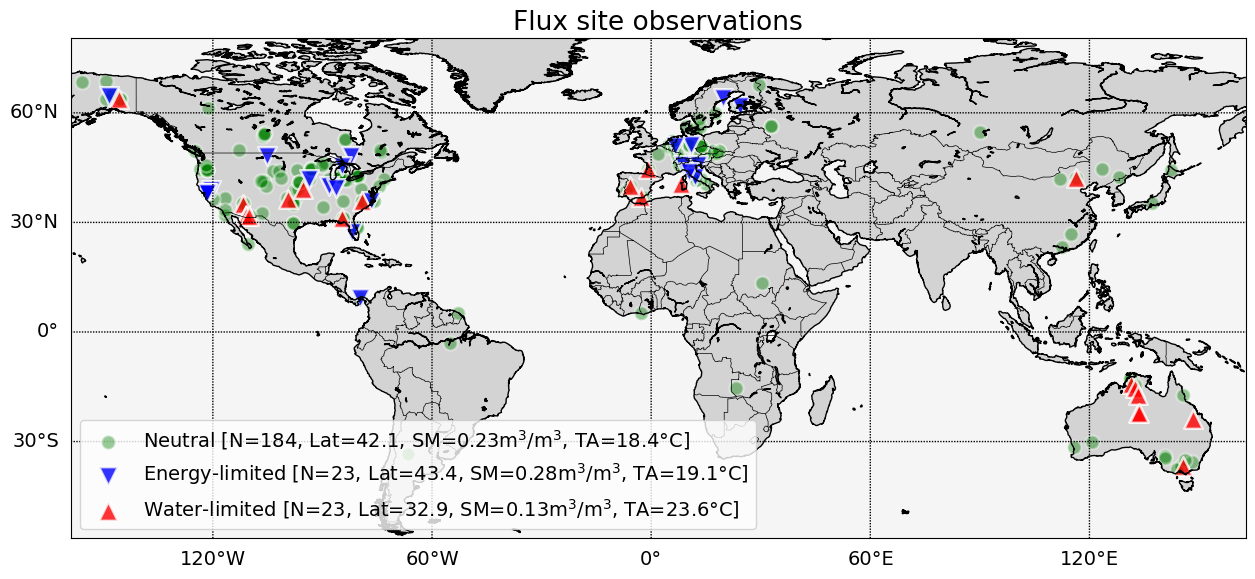

In [11]:
# --- Build Map ---
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
    
region = 'glb'
fname="./CLASP_fig/FluxTowers_site_map.png"

sea = 0
s = season_mon[sea]
fig = plt.figure(figsize=(13,5))
ax = fig.add_axes([0.,0.,1.0,1.0])

map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
              llcrnrlon=lon.min()-1.5, llcrnrlat=lat.min()-1.5, urcrnrlon=lon.max()+1.5, urcrnrlat=lat.max()+1.5)

map.drawcoastlines()
map.drawcountries()
map.drawlsmask(land_color='lightgrey',ocean_color='whitesmoke',lakes=True)
map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=14) # labels=[left,right,upper,bottom]
map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=14)
    
colors = ["green","blue","red"]
markers = ["o","v","^"]
veg = ["Neutral","Energy-limited","Water-limited"]

mm1 = ( np.array(igbp) != 'SAV' ) & ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.14 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)<0.08 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
mm2 = ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.005 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)>0.36 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))

for v,veg_type in enumerate(veg):
    
    if veg_type == "Neutral":
        mm = ( ~mm1 & ~mm2 ) & ( ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0)) )
        msize = 100
        alp = 0.4
    elif veg_type == "Energy-limited":
        mm2 = ( np.array(igbp) != 'SAV' ) & ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.14 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)<0.08 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
        msize = 180
        alp = 0.8
        mm = mm2
    elif veg_type == "Water-limited":
        mm1 = ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.005 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)>0.36 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
        msize = 180
        alp = 0.8
        mm = mm1
    
    avg_lat, avg_sm, avg_ta = np.nanmean(abs(lat)[mm]), np.nanmean(loco_sm[:,s,0][mm,:]/100.), np.nanmean(loco_ta[:,s,0][mm,:])
    print(avg_lat, avg_sm, avg_ta)
    map.scatter(lon[mm], lat[mm], s=msize, label=veg_type+" [N={}, Lat={}, SM={}m$^3$/m$^3$, TA={}°C]".format(mm.sum(),round(avg_lat,1),round(avg_sm,2),round(avg_ta,1)), facecolors=colors[v], marker=markers[v], edgecolors='w', linewidth=1.7, alpha=alp)
      

plt.title("Flux site observations",fontsize=19)
plt.legend(fontsize=14 , labelspacing=0.5, columnspacing=0.5, loc='lower left')
# plt.legend(fontsize=14 , labelspacing=0.5, columnspacing=0.5, loc='lower center')
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [12]:
from scipy.stats import linregress
import math

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        print('lines do not intersect')
        return False
        # x = np.nan
        # y = np.nan
        # raise Exception('lines do not intersect')
    else:
        d = (det(*line1), det(*line2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return x, y

def line_intersection_number(x, y, xval):
    cnt = 0
    for dt in range(24):
        if dt==23:
            if (xval-x[dt])*(xval-x[0])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
    return cnt

def line_intersection_number_3hr(x, y, xval):
    cnt = 0
    for dt in range(8):
        if dt==7:
            if (xval-x[dt])*(xval-x[0])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
    return cnt

def line_intersection_number_6hr(x, y, xval):
    cnt = 0
    for dt in range(4):
        if dt==3:
            if (xval-x[dt])*(xval-x[0])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                cnt = cnt+1
                # xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
    return cnt

def line_intersection_value(x, y, xval, A, B, cc):
    yval = np.empty([cc])
    yval[:] = np.nan
    cnt = 0
    for dt in range(24):
        if dt==23:
            if (xval-x[dt])*(xval-x[0])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
                yval[cnt] = yy
                cnt = cnt+1
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
                yval[cnt] = yy
                cnt = cnt+1
    return yval

def line_intersection_value_3hr(x, y, xval, A, B, cc):
    yval = np.empty([cc])
    yval[:] = np.nan
    cnt = 0
    for dt in range(8):
        if dt==7:
            if (xval-x[dt])*(xval-x[0])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
                yval[cnt] = yy
                cnt = cnt+1
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
                yval[cnt] = yy
                cnt = cnt+1
    return yval

def line_intersection_value_6hr(x, y, xval, A, B, cc):
    yval = np.empty([cc])
    yval[:] = np.nan
    cnt = 0
    for dt in range(4):
        if dt==3:
            if (xval-x[dt])*(xval-x[0])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[0], y[0]]))
                yval[cnt] = yy
                cnt = cnt+1
        else:
            if (xval-x[dt])*(xval-x[dt+1])<0:
                xx, yy = line_intersection((A, B), ([x[dt], y[dt]], [x[dt+1], y[dt+1]]))
                yval[cnt] = yy
                cnt = cnt+1
    return yval

def asym_area_cov(x, y):
    bn = 100
    bw = (x.max()-x.min()) / float(bn)
    xstd = np.std(x)
    ystd = np.std(y)
    xvar = np.var(x)
    yvar = np.var(y)
    xycov = stats.pearsonr(x,y)[0] * xstd * ystd
    asym = 0.
    for b in range(bn):
        A1 = [x.min()+bw*float(b), 0]
        B1 = [x.min()+bw*float(b), 1e+10]
        A2 = [x.min()+bw*float(b+1), 0]
        B2 = [x.min()+bw*float(b+1), 1e+10]
        
        c1 = line_intersection_number(x, y, A1[0])
        c2 = line_intersection_number(x, y, A2[0])
        if c1 == 2:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
        elif c1 == 4:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[3] - yval[2] + yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
            
        del A1
        del A2
        del B1
        del B2
        del c1
        del c2
    del bw                
    return asym*stats.pearsonr(x,y)[0]/(xvar*yvar)

def asym_area(x, y):
    bn = 100
    bw = (x.max()-x.min()) / float(bn)
    xstd = np.std(x)
    ystd = np.std(y)
    xvar = np.var(x)
    yvar = np.var(y)
    asym = 0.
    for b in range(bn):
        A1 = [x.min()+bw*float(b), 0]
        B1 = [x.min()+bw*float(b), 1e+10]
        A2 = [x.min()+bw*float(b+1), 0]
        B2 = [x.min()+bw*float(b+1), 1e+10]
        
        c1 = line_intersection_number(x, y, A1[0])
        c2 = line_intersection_number(x, y, A2[0])
        if c1 == 2:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
        elif c1 == 4:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[3] - yval[2] + yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
            
        del A1
        del A2
        del B1
        del B2
        del c1
        del c2
    del bw                
    return asym/(xstd*ystd), asym/(xstd*ystd)*xvar/(xvar+yvar), asym/(xstd*ystd)*yvar/(xvar+yvar)
    # return asym
    
def asym_area_dis(x, y):
    bn = 100
    bw = (x.max()-x.min()) / float(bn)
    xstd = np.std(x)
    ystd = np.std(y)
    xvar = np.var(x)
    yvar = np.var(y)
    xycov = stats.pearsonr(x,y)[0] * xstd * ystd
    asym = 0.
    for b in range(bn):
        A1 = [x.min()+bw*float(b), 0]
        B1 = [x.min()+bw*float(b), 1e+10]
        A2 = [x.min()+bw*float(b+1), 0]
        B2 = [x.min()+bw*float(b+1), 1e+10]
        
        c1 = line_intersection_number(x, y, A1[0])
        c2 = line_intersection_number(x, y, A2[0])
        if c1 == 2:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
        elif c1 == 4:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[3] - yval[2] + yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
            
        del A1
        del A2
        del B1
        del B2
        del c1
        del c2
    del bw
    
    dis = 0.
    disx = 0.
    disy = 0.
    for t in range(24):
        if t==23:
            dis = dis + (x[0]-x[t])**2 + (y[0]-y[t])**2
            disx = disx + (x[0]-x[t])**2
            disy = disy + (y[0]-y[t])**2
        else:
            dis = dis + (x[t+1]-x[t])**2 + (y[t+1]-y[t])**2
            disx = disx + (x[t+1]-x[t])**2
            disy = disy + (y[t+1]-y[t])**2
    return asym, asym/dis, asym*disx/(dis*dis), asym*disy/(dis*dis)

def asym_area_dis_3hr(x, y):
    bn = 100
    bw = (x.max()-x.min()) / float(bn)
    xstd = np.std(x)
    ystd = np.std(y)
    xvar = np.var(x)
    yvar = np.var(y)
    xycov = stats.pearsonr(x,y)[0] * xstd * ystd
    asym = 0.
    for b in range(bn):
        A1 = [x.min()+bw*float(b), 0]
        B1 = [x.min()+bw*float(b), 1e+10]
        A2 = [x.min()+bw*float(b+1), 0]
        B2 = [x.min()+bw*float(b+1), 1e+10]
        
        c1 = line_intersection_number_3hr(x, y, A1[0])
        c2 = line_intersection_number_3hr(x, y, A2[0])
        if c1 == 2:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value_3hr(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
        elif c1 == 4:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value_3hr(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[3] - yval[2] + yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
            
        del A1
        del A2
        del B1
        del B2
        del c1
        del c2
    del bw
    
    dis = 0.
    disx = 0.
    disy = 0.
    for t in range(8):
        if t==7:
            dis = dis + (x[0]-x[t])**2 + (y[0]-y[t])**2
            disx = disx + (x[0]-x[t])**2
            disy = disy + (y[0]-y[t])**2
        else:
            dis = dis + (x[t+1]-x[t])**2 + (y[t+1]-y[t])**2
            disx = disx + (x[t+1]-x[t])**2
            disy = disy + (y[t+1]-y[t])**2
    return asym, asym/dis, asym*disx/(dis*dis), asym*disy/(dis*dis)

def asym_area_dis_6hr(x, y):
    bn = 100
    bw = (x.max()-x.min()) / float(bn)
    xstd = np.std(x)
    ystd = np.std(y)
    xvar = np.var(x)
    yvar = np.var(y)
    xycov = stats.pearsonr(x,y)[0] * xstd * ystd
    asym = 0.
    for b in range(bn):
        A1 = [x.min()+bw*float(b), 0]
        B1 = [x.min()+bw*float(b), 1e+10]
        A2 = [x.min()+bw*float(b+1), 0]
        B2 = [x.min()+bw*float(b+1), 1e+10]
        
        c1 = line_intersection_number_6hr(x, y, A1[0])
        c2 = line_intersection_number_6hr(x, y, A2[0])
        if c1 == 2:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value_6hr(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
        elif c1 == 4:
            yval = np.empty([c1])
            yval[:] = np.nan
            yval = line_intersection_value_6hr(x, y, A1[0], A1, B1, c1)
            yval.sort()
            bval = ( yval[3] - yval[2] + yval[1] - yval[0] ) * bw
            asym = asym + bval
            del yval
            
        del A1
        del A2
        del B1
        del B2
        del c1
        del c2
    del bw
    
    dis = 0.
    disx = 0.
    disy = 0.
    for t in range(4):
        if t==3:
            dis = dis + (x[0]-x[t])**2 + (y[0]-y[t])**2
            disx = disx + (x[0]-x[t])**2
            disy = disy + (y[0]-y[t])**2
        else:
            dis = dis + (x[t+1]-x[t])**2 + (y[t+1]-y[t])**2
            disx = disx + (x[t+1]-x[t])**2
            disy = disy + (y[t+1]-y[t])**2
    return asym, asym/dis, asym*disx/(dis*dis), asym*disy/(dis*dis)

In [20]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

import metpy.calc as mpcalc
from metpy.units import units

xlim1 = 23000
xlim2 = 26500
ylim1 = 289000
ylim2 = 310000
# ax.set_ylim([290000, 310000])
# ax.set_xlim([23000, 26500])

num = 3000
endpoint = True

xar1 = np.linspace(xlim1, xlim2, num, endpoint)
yar1 = np.linspace(ylim1, ylim2, num, endpoint)
xar = xar1 / 2.5e+6
yar = yar1 / 1005. / ( ( 100./101.325 ) ** (0.286) )

pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')

rhs = np.linspace(10, 100, 10, endpoint)
rh_range = mpcalc.relative_humidity_from_specific_humidity(pa,np.flip(ta),q).to('percent')

far = np.empty([10,num]) # temperature
far[:] = np.nan

for x, xx in enumerate(q):
    rh1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,xx).to('percent')
    for l, rh in enumerate(rhs):
        a,b = find_nearest(rh1,rh)
        far[l,x] = 1005. * yar[a] * ( 100./101.325 ) ** (0.286)

NameError: name 'units' is not defined

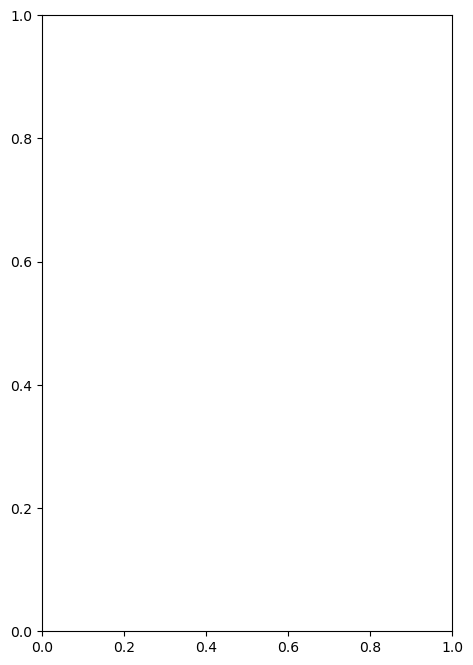

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches
from labellines import labelLine, labelLines

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

sea = 0
axis_lim = False
fac = 0.7
s = season_mon[sea]

xylab = ['L$_v$q [J/kg]', r'C$_p$$\dot{\Theta}$ [J/kg]']
xylab3 = ['M$_{sfc}$ [J/kg/hr]', 'F$_{sfc}$ [J/kg/hr]']
xylab4 = ['M$_{atm}$ [J/kg/hr]', 'F$_{atm}$ [J/kg/hr]']
xylab1 = ['∑M$_{sfc}$ [J/kg]', '∑F$_{sfc}$ [J/kg]']
xylab2 = ['∑M$_{atm}$ [J/kg]', '∑F$_{atm}$ [J/kg]']

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
lim1 = 170
lim2 = 35
lim3 = 440
lst = [x for x in range(24)]

fig = plt.figure(figsize=(18,8))
fname="./CLASP_fig/FluxTowers_asy.png"
subtitle = ['(a) Hourly Mixing diagram','(b) 3-Hourly Mixing diagram','(c) 6-Hourly Mixing diagram']

mm1 = ( np.array(igbp) != 'SAV' ) & ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.14 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)<0.08 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
mm2 = ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.005 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)>0.36 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))

ax = fig.add_subplot(131)
x1, y1 = np.nanmean(np.nanmean(loco_q[:,s,1:][mm1,:,:],axis=1),axis=0), np.nanmean(np.nanmean(loco_t[:,s,1:][mm1,:,:],axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
z1, v1 = np.nanmean(np.nanmean(loco_q[:,s,1:][mm2,:,:],axis=1),axis=0), np.nanmean(np.nanmean(loco_t[:,s,1:][mm2,:,:],axis=1),axis=0)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)

xar = x1 / 2.5e+6
yar = y1 / 1005. / ( ( 100./101.325 ) ** (0.286) )
pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')
c1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,q).to('percent')

xar = z1 / 2.5e+6
yar = v1 / 1005. / ( ( 100./101.325 ) ** (0.286) )
pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')
d1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,q).to('percent')

cc2 = np.nanmean(c1)
dd2 = np.nanmean(d1)


# ax.plot(xar1,far[1,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='20%')
ax.plot(xar1,far[2,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='30%')
ax.plot(xar1,far[3,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='40%')
ax.plot(xar1,far[4,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='50%')
ax.plot(xar1,far[5,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='60%')
ax.plot(xar1,far[6,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='70%')
ax.plot(xar1,far[7,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='80%')
ax.plot(xar1,far[8,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='90%')
labelLines(ax.get_lines(), align=False, fontsize=14, zorder=0.5)

poly1 = np.empty([len(lst),2])
poly1[:] = np.nan
poly1[:,0] = x1
poly1[:,1] = y1
poly = patches.Polygon(poly1, color='blue',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

# poly = patches.Polygon(poly1, color='blue',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
# ax.add_patch(poly)

poly1 = np.empty([len(lst),2])
poly1[:] = np.nan
poly1[:,0] = z1
poly1[:,1] = v1
poly = patches.Polygon(poly1, color='red',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

# poly = patches.Polygon(poly1, color='red',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
# ax.add_patch(poly)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, fill=False, edgecolor='blue', zorder=4, alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')


cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, fill=False, edgecolor='red', zorder=4, alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[0]),fontsize=17)      
# ax.set_yscale("log") 


aa1, aa2, aa3, aa4 = asym_area_dis(z1,v1)
bb1, bb2, bb3, bb4 = asym_area_dis(x1,y1)

# ax.annotate('{} [J/kg]$^2$'.format(sci_notation(aa1,2)),
ax.annotate('{}'.format(round(aa1/1000000,2)),
            xy=(0.8, 0.85), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            color='red',fontsize=14, weight='bold')
# ax.annotate('{} [J/kg]$^2$'.format(sci_notation(bb1,2)),
ax.annotate('{}'.format(round(bb1/1000000,2)),
            xy=(0.8, 0.25), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            color='blue',fontsize=14, weight='bold')

ax.set_ylim([289000, 310000])
ax.set_xlim([23000, 26500])

ax = fig.add_subplot(132)
lst31 = [x for x in range(0,24,3)]
lst32 = [x for x in range(1,24,3)]
lst33 = [x for x in range(2,24,3)]

# ax.plot(xar1,far[1,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='20%')
ax.plot(xar1,far[2,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='30%')
ax.plot(xar1,far[3,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='40%')
ax.plot(xar1,far[4,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='50%')
ax.plot(xar1,far[5,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='60%')
ax.plot(xar1,far[6,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='70%')
ax.plot(xar1,far[7,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='80%')
ax.plot(xar1,far[8,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='90%')
labelLines(ax.get_lines(), align=False, fontsize=14, zorder=0.5)

poly1 = np.empty([len(lst31),2])
poly2 = np.empty([len(lst31),2])
poly3 = np.empty([len(lst31),2])
poly1[:] = np.nan
poly2[:] = np.nan
poly3[:] = np.nan
poly1[:,0] = x1[lst31]
poly1[:,1] = y1[lst31]
poly2[:,0] = x1[lst32]
poly2[:,1] = y1[lst32]
poly3[:,0] = x1[lst33]
poly3[:,1] = y1[lst33]
poly = patches.Polygon(poly1, color='blue',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='darkcyan',linestyle='dashdot',linewidth=2, alpha=0.3, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='limegreen',linestyle='dashed',linewidth=2, alpha=0.3, zorder=2.2)
ax.add_patch(poly)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

poly = patches.Polygon(poly1, color='blue',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='darkcyan',fill=False,linestyle='dashdot',linewidth=2, alpha=0.6, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='limegreen',fill=False,linestyle='dashed',linewidth=2, alpha=0.6, zorder=2.2)
ax.add_patch(poly)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst31):
    circle = patches.Rectangle((x1[txt]-(x_max-x_min)*0.05/2, y1[txt]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[txt],ccc0[txt],ccc2[txt],ccc3[txt]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Rectangle((x1[txt]-(x_max-x_min)*0.05/2, y1[txt]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, fill=False, edgecolor='blue', zorder=4, alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(txt, xy=(x1[txt], y1[txt]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')

poly1 = np.empty([len(lst31),2])
poly2 = np.empty([len(lst31),2])
poly3 = np.empty([len(lst31),2])
poly1[:] = np.nan
poly2[:] = np.nan
poly3[:] = np.nan
poly1[:,0] = z1[lst31]
poly1[:,1] = v1[lst31]
poly2[:,0] = z1[lst32]
poly2[:,1] = v1[lst32]
poly3[:,0] = z1[lst33]
poly3[:,1] = v1[lst33]
poly = patches.Polygon(poly1, color='red',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='chocolate',linestyle='dashdot',linewidth=2, alpha=0.3, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='darkorange',linestyle='dashed',linewidth=2, alpha=0.3, zorder=2.2)
ax.add_patch(poly)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

poly = patches.Polygon(poly1, color='red',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='chocolate',fill=False,linestyle='dashdot',linewidth=2, alpha=0.6, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='darkorange',fill=False,linestyle='dashed',linewidth=2, alpha=0.6, zorder=2.2)
ax.add_patch(poly)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst31):
    circle = patches.Ellipse((z1[txt], v1[txt]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[txt],ccc0[txt],ccc2[txt],ccc3[txt]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Ellipse((z1[txt], v1[txt]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, fill=False, edgecolor='red', zorder=4, alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(txt, xy=(z1[txt], v1[txt]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')

aa11, aa12, aa13, aa14 = asym_area_dis_3hr(z1[lst31],v1[lst31])
aa21, aa22, aa23, aa24 = asym_area_dis_3hr(z1[lst32],v1[lst32])
aa31, aa32, aa33, aa34 = asym_area_dis_3hr(z1[lst33],v1[lst33])
# ax.annotate('S0:{} [J/kg]$^2$\nS1:{} [J/kg]$^2$\nS2:{} [J/kg]$^2$'.format(sci_notation(aa11,2),sci_notation(aa21,2),sci_notation(aa31,2)),
# ax.annotate('S0:{} [J/kg]$^2$\nS1:{}\nS2:{}'.format(sci_notation(aa11,2),sci_notation(aa21,2),sci_notation(aa31,2)),
# ax.annotate('S0:{}\nS1:{}\nS2:{}'.format(round(aa11/1000000,2),round(aa21/1000000,2),round(aa31/1000000,2)),
#             xy=(0.8, 0.9), xycoords='axes fraction',
#             horizontalalignment='left', verticalalignment='top',
#             color='red',fontsize=14)
ax.annotate('S0:{}'.format(round(aa11/1000000,2)),xy=(0.8, 0.9), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='red', fontsize=14, weight='bold')
ax.annotate('S1:{}'.format(round(aa21/1000000,2)),xy=(0.8, 0.85), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='chocolate', fontsize=14, weight='bold')
ax.annotate('S2:{}'.format(round(aa31/1000000,2)),xy=(0.8, 0.8), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='darkorange', fontsize=14, weight='bold')

bb11, bb12, bb13, bb14 = asym_area_dis_3hr(x1[lst31],y1[lst31])
bb21, bb22, bb23, bb24 = asym_area_dis_3hr(x1[lst32],y1[lst32])
bb31, bb32, bb33, bb34 = asym_area_dis_3hr(x1[lst33],y1[lst33])
# ax.annotate('S0:{} [J/kg]$^2$\nS1:{} [J/kg]$^2$\nS2:{} [J/kg]$^2$'.format(sci_notation(bb11,2),sci_notation(bb21,2),sci_notation(bb31,2)),
# ax.annotate('S0:{} [J/kg]$^2$\nS1:{}\nS2:{}'.format(sci_notation(bb11,2),sci_notation(bb21,2),sci_notation(bb31,2)),
# ax.annotate('S0:{}\nS1:{}\nS2:{}'.format(round(bb11/1000000,2),round(bb21/1000000,2),round(bb31/1000000,2)),
#             xy=(0.8, 0.25), xycoords='axes fraction',
#             horizontalalignment='left', verticalalignment='top',
#             color='blue',fontsize=14)
ax.annotate('S0:{}'.format(round(bb11/1000000,2)),xy=(0.8, 0.35), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='blue', fontsize=14, weight='bold')
ax.annotate('S1:{}'.format(round(bb21/1000000,2)),xy=(0.8, 0.3), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='darkcyan', fontsize=14, weight='bold')
ax.annotate('S2:{}'.format(round(bb31/1000000,2)),xy=(0.8, 0.25), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='limegreen', fontsize=14, weight='bold')

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=16)
# ax.set_ylabel(xylab[1], labelpad = 1,fontsize=16)
ax.set_ylabel('', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[1]),fontsize=17)   

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], linestyle='solid', label='starting at 0LST (S0)'),
           Line2D([0], [0], linestyle='dashdot', label='starting at 1LST (S1)'),
           Line2D([0], [0], linestyle='dashed', label='starting at 2LST (S2)')]
ax.legend(handles=handles,fontsize=13,loc='center left')

ax.set_ylim([289000, 310000])
ax.set_xlim([23000, 26500])

ax = fig.add_subplot(133)
lst61 = [x for x in range(0,24,6)]
lst62 = [x for x in range(2,24,6)]
lst63 = [x for x in range(4,24,6)]

# ax.plot(xar1,far[1,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='20%')
ax.plot(xar1,far[2,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='30%')
ax.plot(xar1,far[3,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='40%')
ax.plot(xar1,far[4,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='50%')
ax.plot(xar1,far[5,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='60%')
ax.plot(xar1,far[6,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='70%')
ax.plot(xar1,far[7,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='80%')
ax.plot(xar1,far[8,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='90%')
labelLines(ax.get_lines(), align=False, fontsize=14, zorder=0.5)

poly1 = np.empty([len(lst61),2])
poly2 = np.empty([len(lst61),2])
poly3 = np.empty([len(lst61),2])
poly1[:] = np.nan
poly2[:] = np.nan
poly3[:] = np.nan
poly1[:,0] = x1[lst61]
poly1[:,1] = y1[lst61]
poly2[:,0] = x1[lst62]
poly2[:,1] = y1[lst62]
poly3[:,0] = x1[lst63]
poly3[:,1] = y1[lst63]
poly = patches.Polygon(poly1, color='blue',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='darkcyan',linestyle='dashdot',linewidth=2, alpha=0.3, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='limegreen',linestyle='dashed',linewidth=2, alpha=0.3, zorder=2.2)
ax.add_patch(poly)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

poly = patches.Polygon(poly1, color='blue',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='darkcyan',fill=False,linestyle='dashdot',linewidth=2, alpha=0.6, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='limegreen',fill=False,linestyle='dashed',linewidth=2, alpha=0.6, zorder=2.2)
ax.add_patch(poly)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst61):
    # circle = patches.Rectangle((x1[txt]-(x_max-x_min)*0.05/2, y1[txt]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[txt],ccc0[txt],ccc2[txt],ccc3[txt]), edgecolor='blue', zorder=4)
    circle = patches.Rectangle((x1[txt]-(x_max-x_min)*0.05/2, y1[txt]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[txt],ccc0[txt],ccc2[txt],ccc3[txt]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Rectangle((x1[txt]-(x_max-x_min)*0.05/2, y1[txt]-(y_max-y_min)*0.05*fac/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac,fill=False, edgecolor='blue', zorder=4, alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(txt, xy=(x1[txt], y1[txt]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')

poly1 = np.empty([len(lst61),2])
poly2 = np.empty([len(lst61),2])
poly3 = np.empty([len(lst61),2])
poly1[:] = np.nan
poly2[:] = np.nan
poly3[:] = np.nan
poly1[:,0] = z1[lst61]
poly1[:,1] = v1[lst61]
poly2[:,0] = z1[lst62]
poly2[:,1] = v1[lst62]
poly3[:,0] = z1[lst63]
poly3[:,1] = v1[lst63]
poly = patches.Polygon(poly1, color='red',linestyle='solid',linewidth=2, alpha=0.3, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='chocolate',linestyle='dashdot',linewidth=2, alpha=0.3, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='darkorange',linestyle='dashed',linewidth=2, alpha=0.3, zorder=2.2)
ax.add_patch(poly)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', linewidth=1.8, edgecolors='black', alpha=0.8, zorder=10)

poly = patches.Polygon(poly1, color='red',fill=False,linestyle='solid',linewidth=2, alpha=0.6, zorder=2)
ax.add_patch(poly)
poly = patches.Polygon(poly2, color='chocolate',fill=False,linestyle='dashdot',linewidth=2, alpha=0.6, zorder=2.1)
ax.add_patch(poly)
poly = patches.Polygon(poly3, color='darkorange',fill=False,linestyle='dashed',linewidth=2, alpha=0.6, zorder=2.2)
ax.add_patch(poly)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst61):
    circle = patches.Ellipse((z1[txt], v1[txt]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, facecolor=cmap(ccc1[txt],ccc0[txt],ccc2[txt],ccc3[txt]*0.7), zorder=4)
    ax.add_patch(circle)
    circle = patches.Ellipse((z1[txt], v1[txt]), (x_max-x_min)*0.05, (y_max-y_min)*0.05*fac, fill=False, edgecolor='red', zorder=4, alpha=0.5)
    ax.add_patch(circle)
    ax.annotate(txt, xy=(z1[txt], v1[txt]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13, zorder=5, alpha=0.8, weight='bold')

aa11, aa12, aa13, aa14 = asym_area_dis_6hr(z1[lst61],v1[lst61])
aa21, aa22, aa23, aa24 = asym_area_dis_6hr(z1[lst62],v1[lst62])
aa31, aa32, aa33, aa34 = asym_area_dis_6hr(z1[lst63],v1[lst63])
# ax.annotate('S0:{} [J/kg]$^2$\nS2:{} [J/kg]$^2$\nS4:{} [J/kg]$^2$'.format(sci_notation(aa11,2),sci_notation(aa21,2),sci_notation(aa31,2)),
# ax.annotate('S0:{} [J/kg]$^2$\nS2:{}\nS4:{}'.format(sci_notation(aa11,2),sci_notation(aa21,2),sci_notation(aa31,2)),
# ax.annotate('S0:{}\nS2:{}\nS4:{}'.format(round(aa11/1000000,2),round(aa21/1000000,2),round(aa31/1000000,2)),
#             xy=(0.8, 0.9), xycoords='axes fraction',
#             horizontalalignment='left', verticalalignment='top',
#             color='red',fontsize=14)
ax.annotate('S0:{}'.format(round(aa11/1000000,2)),xy=(0.8, 0.9), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='red', fontsize=14, weight='bold')
ax.annotate('S2:{}'.format(round(aa21/1000000,2)),xy=(0.8, 0.85), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='chocolate', fontsize=14, weight='bold')
ax.annotate('S4:{}'.format(round(aa31/1000000,2)),xy=(0.8, 0.8), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='darkorange', fontsize=14, weight='bold')

bb11, bb12, bb13, bb14 = asym_area_dis_6hr(x1[lst61],y1[lst61])
bb21, bb22, bb23, bb24 = asym_area_dis_6hr(x1[lst62],y1[lst62])
bb31, bb32, bb33, bb34 = asym_area_dis_6hr(x1[lst63],y1[lst63])
# ax.annotate('S0:{} [J/kg]$^2$\nS2:{} [J/kg]$^2$\nS4:{} [J/kg]$^2$'.format(sci_notation(bb11,2),sci_notation(bb21,2),sci_notation(bb31,2)),
# ax.annotate('S0:{} [J/kg]$^2$\nS2:{}\nS4:{}'.format(sci_notation(bb11,2),sci_notation(bb21,2),sci_notation(bb31,2)),
# ax.annotate('S0:{}\nS2:{}\nS4:{}'.format(round(bb11/1000000,2),round(bb21/1000000,2),round(bb31/1000000,2)),
#             xy=(0.8, 0.25), xycoords='axes fraction',
#             horizontalalignment='left', verticalalignment='top',
#             color='blue',fontsize=14)
ax.annotate('S0:{}'.format(round(bb11/1000000,2)),xy=(0.8, 0.35), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='blue', fontsize=14, weight='bold')
ax.annotate('S2:{}'.format(round(bb21/1000000,2)),xy=(0.8, 0.3), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='darkcyan', fontsize=14, weight='bold')
ax.annotate('S4:{}'.format(round(bb31/1000000,2)),xy=(0.8, 0.25), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', color='limegreen', fontsize=14, weight='bold')

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=16)
# ax.set_ylabel(xylab[1], labelpad = 1,fontsize=16)
ax.set_ylabel('', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[2]),fontsize=17)   

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], linestyle='solid', label='starting at 0LST (S0)'),
           Line2D([0], [0], linestyle='dashdot', label='starting at 2LST (S2)'),
           Line2D([0], [0], linestyle='dashed', label='starting at 4LST (S4)')]
ax.legend(handles=handles,fontsize=13,loc='center left')

ax.set_ylim([289000, 310000])
ax.set_xlim([23000, 26500])
# ax.set_yticks([])

fig.tight_layout()

# plt.ylim([290000, 310000])
# plt.xlim([23000, 26500])

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()